# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.22KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

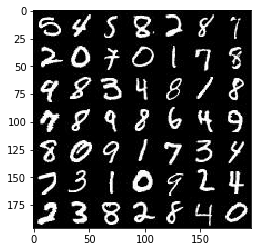

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

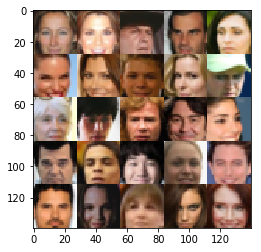

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(dtype = tf.float32, shape = [None, image_height, image_width, image_channels], name = 'real_inputs')
    generation_seeds = tf.placeholder(dtype = tf.float32, shape = [None, z_dim], name = 'generation_seeds')
    learning_rate = tf.placeholder(dtype = tf.float32, name = 'learning_rate')

    return real_inputs, generation_seeds, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse = False, alpha = 0.2, drop_rate = 0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    is_train = not reuse
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h, w, c = 28, 28, 4  # Input
                
        disc_flow = tf.layers.conv2d(
            inputs = images, 
            filters = 128, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same')
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate / 4, seed = 17)
        
        h, w, c = 14, 14, 128
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 256, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same') 
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = True) # is_train)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate / 2, seed = 17)
        
        h, w, c = 7, 7, 256
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 512, 
            kernel_size = 3, 
            strides = 1,
            padding = 'same')
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = True) # is_train)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 7, 7, 512
        
        disc_flow = tf.reshape(
            tensor = disc_flow, 
            shape = [-1, h * w * c])
        disc_flow = tf.layers.dense(
            inputs = disc_flow, 
            units = 1)
        output = tf.tanh(disc_flow)
        
    return output, disc_flow

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2, drop_rate = 0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse = not is_train):
    
        h, w, c = 7, 7, 512  # Start

        gen_flow = tf.layers.dense(
            inputs = z,
            units = h * w * c)
        gen_flow = tf.reshape(
            tensor = gen_flow, 
            shape = [-1, h, w, c])
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)

        h, w, c = 7, 7, 512

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 256, 
            kernel_size = 3, 
            strides = 1, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)

        h, w, c = 7, 7, 256

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 128, 
            kernel_size = 3, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate / 2, seed = 17)
        
        h, w, c = 14, 14, 128
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 64, 
            kernel_size = 3, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate / 4, seed = 17)
        
        h, w, c = 28, 28, 64
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = out_channel_dim, 
            kernel_size = 5, 
            strides = 1, 
            padding = 'same')
        
        h, w, c = 28, 28, out_channel_dim
        
        out = tf.tanh(gen_flow)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01, drop_rate = 0.1, smoothing_rate = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    input_real = tf.multiply(input_real, 2)  # Scale input images by 2 from [-.5,.5] -> [-1,1]

    g_out = generator(z = input_z, out_channel_dim = out_channel_dim, is_train = True, alpha = alpha, drop_rate = drop_rate)
    d_real_out, d_real_layer = discriminator(images = input_real, reuse = False, alpha = alpha, drop_rate = drop_rate)
    d_fake_out, d_fake_layer = discriminator(images = g_out, reuse = True, alpha = alpha, drop_rate = drop_rate)
    
    g_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.multiply(tf.ones_like(d_fake_out), 1. - smoothing_rate)))
    
    d_real_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_real_layer, 
            labels = tf.multiply(tf.ones_like(d_real_out), 1. - smoothing_rate)))
    d_fake_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.multiply(tf.ones_like(d_fake_out), 0. + smoothing_rate)))

    d_loss = d_real_loss + d_fake_loss

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(
    epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
    drop_rate = 0.1, alpha = 0.2, smoothing_rate = 0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    tf.reset_default_graph()
    
    real_inputs, generation_seeds, lr = model_inputs(
        image_width = data_shape[1], 
        image_height =  data_shape[2], 
        image_channels = data_shape[3], 
        z_dim = z_dim)
    
    d_loss, g_loss = model_loss(
        input_real = real_inputs, 
        input_z = generation_seeds, 
        out_channel_dim = data_shape[3], 
        alpha = alpha,
        drop_rate = drop_rate,
        smoothing_rate = smoothing_rate)

    g_opt, d_opt = model_opt(
        d_loss = d_loss, 
        g_loss = g_loss, 
        learning_rate = lr, 
        beta1 = beta1)    

    steps = 0
    # saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for x in get_batches(batch_size):
                
                steps += 1

                z = np.random.uniform(low = -1, high = 1, size = [batch_size, z_dim])

                feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate}
                
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})

                if steps % 16 == 0:
                    
                    d_train_loss = d_loss.eval({generation_seeds: z, real_inputs: x})
                    g_train_loss = g_loss.eval({generation_seeds: z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "D Loss: {:.4f}...".format(d_train_loss),
                          "G Loss: {:.4f}".format(g_train_loss))
                    
                if steps % 128 == 0:
                    
                    show_generator_output(
                        sess = sess, 
                        n_images = 25, 
                        input_z = generation_seeds, 
                        out_channel_dim = data_shape[3], 
                        image_mode = data_image_mode)

        # saver.save(sess, './checkpoints/generator.ckpt')                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... D Loss: 0.8312... G Loss: 4.0779
Epoch 1/2... D Loss: 0.8005... G Loss: 1.2827
Epoch 1/2... D Loss: 0.8056... G Loss: 1.3182
Epoch 1/2... D Loss: 0.8982... G Loss: 1.0042
Epoch 1/2... D Loss: 0.8521... G Loss: 1.2021
Epoch 1/2... D Loss: 0.8602... G Loss: 1.0818
Epoch 1/2... D Loss: 0.8104... G Loss: 1.1905
Epoch 1/2... D Loss: 0.7862... G Loss: 1.2436


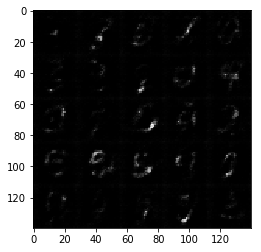

Epoch 1/2... D Loss: 0.7958... G Loss: 1.2502
Epoch 1/2... D Loss: 0.8982... G Loss: 0.9516
Epoch 1/2... D Loss: 0.7457... G Loss: 1.4582
Epoch 1/2... D Loss: 0.8345... G Loss: 1.1432
Epoch 1/2... D Loss: 0.8244... G Loss: 1.1465
Epoch 1/2... D Loss: 0.8510... G Loss: 1.0578
Epoch 1/2... D Loss: 0.8427... G Loss: 1.0825
Epoch 1/2... D Loss: 0.8180... G Loss: 1.5975


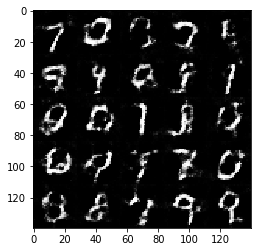

Epoch 1/2... D Loss: 0.8801... G Loss: 1.0372
Epoch 1/2... D Loss: 0.9951... G Loss: 0.8463
Epoch 1/2... D Loss: 0.7788... G Loss: 1.3731
Epoch 1/2... D Loss: 0.8080... G Loss: 1.3494
Epoch 1/2... D Loss: 0.7929... G Loss: 1.3608
Epoch 1/2... D Loss: 0.7737... G Loss: 1.4327
Epoch 1/2... D Loss: 0.8570... G Loss: 1.0726
Epoch 1/2... D Loss: 0.8331... G Loss: 1.4692


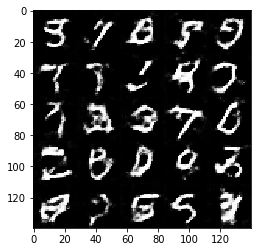

Epoch 1/2... D Loss: 0.8264... G Loss: 1.1383
Epoch 1/2... D Loss: 0.8645... G Loss: 1.0323
Epoch 1/2... D Loss: 0.8116... G Loss: 1.2283
Epoch 1/2... D Loss: 0.8025... G Loss: 1.1833
Epoch 1/2... D Loss: 0.7762... G Loss: 1.3945
Epoch 1/2... D Loss: 0.8615... G Loss: 1.1064
Epoch 1/2... D Loss: 0.7734... G Loss: 1.3878
Epoch 1/2... D Loss: 0.8500... G Loss: 1.1082


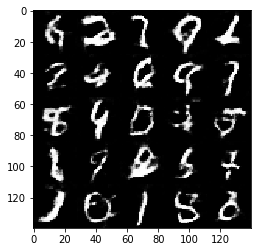

Epoch 1/2... D Loss: 0.8540... G Loss: 1.1064
Epoch 1/2... D Loss: 1.3976... G Loss: 0.5759
Epoch 1/2... D Loss: 0.7372... G Loss: 1.4114
Epoch 1/2... D Loss: 1.4077... G Loss: 0.6732
Epoch 1/2... D Loss: 0.8714... G Loss: 1.0712
Epoch 1/2... D Loss: 0.7476... G Loss: 1.3923
Epoch 1/2... D Loss: 0.7932... G Loss: 1.2200
Epoch 1/2... D Loss: 0.8371... G Loss: 1.1395


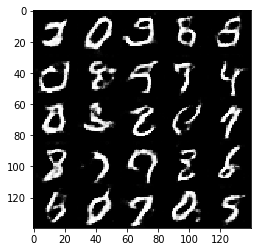

Epoch 1/2... D Loss: 0.8053... G Loss: 1.2223
Epoch 1/2... D Loss: 0.7559... G Loss: 1.9476
Epoch 1/2... D Loss: 0.8445... G Loss: 1.1340
Epoch 1/2... D Loss: 0.8251... G Loss: 1.3929
Epoch 1/2... D Loss: 0.7193... G Loss: 1.6380
Epoch 1/2... D Loss: 0.7810... G Loss: 1.3164
Epoch 1/2... D Loss: 0.8078... G Loss: 1.1949
Epoch 1/2... D Loss: 0.7745... G Loss: 1.5745


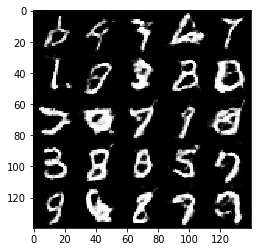

Epoch 1/2... D Loss: 0.8209... G Loss: 1.1244
Epoch 1/2... D Loss: 0.9168... G Loss: 1.0201
Epoch 1/2... D Loss: 0.7993... G Loss: 1.2487
Epoch 1/2... D Loss: 0.7741... G Loss: 1.4793
Epoch 1/2... D Loss: 0.7502... G Loss: 1.3804
Epoch 1/2... D Loss: 0.8777... G Loss: 1.0959
Epoch 1/2... D Loss: 1.0291... G Loss: 0.8673
Epoch 1/2... D Loss: 0.7959... G Loss: 1.5460


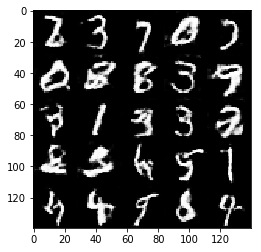

Epoch 1/2... D Loss: 0.7266... G Loss: 1.6105
Epoch 1/2... D Loss: 0.8238... G Loss: 1.1845
Epoch 2/2... D Loss: 0.8163... G Loss: 1.3090
Epoch 2/2... D Loss: 0.7731... G Loss: 1.3247
Epoch 2/2... D Loss: 0.8755... G Loss: 1.0273
Epoch 2/2... D Loss: 1.0115... G Loss: 0.8365
Epoch 2/2... D Loss: 0.7366... G Loss: 1.5483
Epoch 2/2... D Loss: 0.7946... G Loss: 1.3438


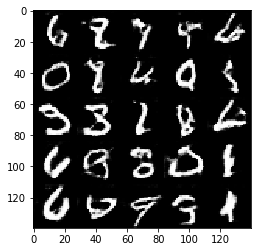

Epoch 2/2... D Loss: 0.8382... G Loss: 1.1008
Epoch 2/2... D Loss: 0.7353... G Loss: 1.7093
Epoch 2/2... D Loss: 0.7568... G Loss: 1.5178
Epoch 2/2... D Loss: 0.8410... G Loss: 1.0902
Epoch 2/2... D Loss: 0.7171... G Loss: 1.5781
Epoch 2/2... D Loss: 0.7583... G Loss: 1.5198
Epoch 2/2... D Loss: 0.7851... G Loss: 1.3107
Epoch 2/2... D Loss: 0.7349... G Loss: 1.4748


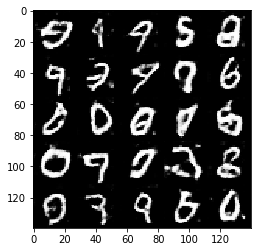

Epoch 2/2... D Loss: 1.0030... G Loss: 0.8399
Epoch 2/2... D Loss: 0.7674... G Loss: 1.5486
Epoch 2/2... D Loss: 0.7635... G Loss: 1.3713
Epoch 2/2... D Loss: 0.7359... G Loss: 1.5002
Epoch 2/2... D Loss: 0.7541... G Loss: 1.4185
Epoch 2/2... D Loss: 0.8000... G Loss: 1.2819
Epoch 2/2... D Loss: 0.8214... G Loss: 1.2937
Epoch 2/2... D Loss: 0.8174... G Loss: 1.1359


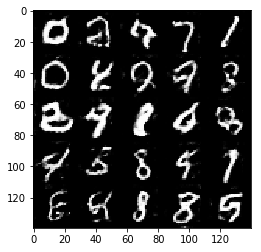

Epoch 2/2... D Loss: 0.7885... G Loss: 1.2895
Epoch 2/2... D Loss: 0.7303... G Loss: 1.8834
Epoch 2/2... D Loss: 0.9839... G Loss: 0.9283
Epoch 2/2... D Loss: 0.7455... G Loss: 1.7915
Epoch 2/2... D Loss: 0.8074... G Loss: 1.2214
Epoch 2/2... D Loss: 0.7502... G Loss: 1.4616
Epoch 2/2... D Loss: 0.7748... G Loss: 1.3140
Epoch 2/2... D Loss: 0.9441... G Loss: 0.9382


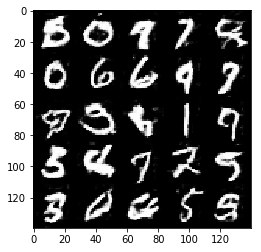

Epoch 2/2... D Loss: 0.7905... G Loss: 1.2605
Epoch 2/2... D Loss: 0.7435... G Loss: 1.4139
Epoch 2/2... D Loss: 0.8632... G Loss: 1.2058
Epoch 2/2... D Loss: 0.8045... G Loss: 1.2961
Epoch 2/2... D Loss: 0.8841... G Loss: 1.0255
Epoch 2/2... D Loss: 0.7304... G Loss: 1.6657
Epoch 2/2... D Loss: 0.8245... G Loss: 1.2204
Epoch 2/2... D Loss: 0.9708... G Loss: 0.9949


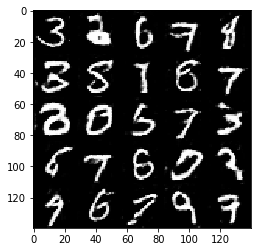

Epoch 2/2... D Loss: 0.7327... G Loss: 1.5656
Epoch 2/2... D Loss: 0.7680... G Loss: 1.3581
Epoch 2/2... D Loss: 0.7348... G Loss: 1.8165
Epoch 2/2... D Loss: 0.8313... G Loss: 1.1268
Epoch 2/2... D Loss: 0.6997... G Loss: 1.7550
Epoch 2/2... D Loss: 0.8619... G Loss: 1.1056
Epoch 2/2... D Loss: 0.8353... G Loss: 1.1926
Epoch 2/2... D Loss: 0.9216... G Loss: 0.9758


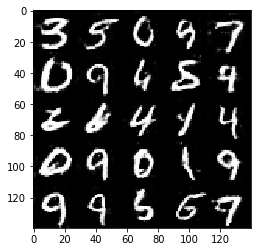

Epoch 2/2... D Loss: 0.7525... G Loss: 1.3864
Epoch 2/2... D Loss: 0.7922... G Loss: 1.3377
Epoch 2/2... D Loss: 0.7216... G Loss: 2.0066
Epoch 2/2... D Loss: 0.8419... G Loss: 1.1160
Epoch 2/2... D Loss: 0.7121... G Loss: 1.6225
Epoch 2/2... D Loss: 0.8124... G Loss: 1.1884
Epoch 2/2... D Loss: 0.7207... G Loss: 1.6327
Epoch 2/2... D Loss: 0.8182... G Loss: 1.4987


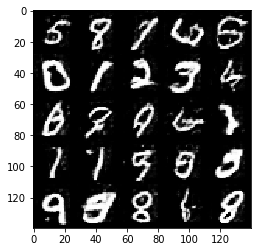

Epoch 2/2... D Loss: 0.9137... G Loss: 1.0020
Epoch 2/2... D Loss: 0.8113... G Loss: 1.3137
Epoch 2/2... D Loss: 0.7905... G Loss: 1.3105
Epoch 2/2... D Loss: 0.7840... G Loss: 1.2593
Epoch 2/2... D Loss: 0.7849... G Loss: 1.3795


IndexError: list index out of range

In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5
drop_rate = 0.
smoothing_rate = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 
          alpha = alpha, drop_rate = drop_rate, smoothing_rate = smoothing_rate)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... D Loss: 0.7115... G Loss: 2.4929
Epoch 1/1... D Loss: 0.8668... G Loss: 1.7445
Epoch 1/1... D Loss: 0.7193... G Loss: 2.6729
Epoch 1/1... D Loss: 0.7436... G Loss: 3.1144
Epoch 1/1... D Loss: 1.0701... G Loss: 0.9498
Epoch 1/1... D Loss: 0.6791... G Loss: 2.0915
Epoch 1/1... D Loss: 0.7720... G Loss: 1.7853
Epoch 1/1... D Loss: 1.0763... G Loss: 0.7549


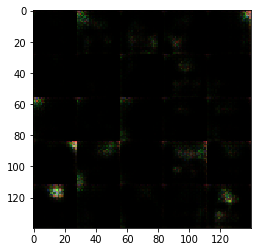

Epoch 1/1... D Loss: 0.6855... G Loss: 2.0884
Epoch 1/1... D Loss: 0.6999... G Loss: 2.1507
Epoch 1/1... D Loss: 0.6889... G Loss: 1.9400
Epoch 1/1... D Loss: 0.7313... G Loss: 2.6399
Epoch 1/1... D Loss: 0.6859... G Loss: 2.0973
Epoch 1/1... D Loss: 0.6949... G Loss: 2.4298
Epoch 1/1... D Loss: 0.7504... G Loss: 1.4852
Epoch 1/1... D Loss: 0.7195... G Loss: 1.5890


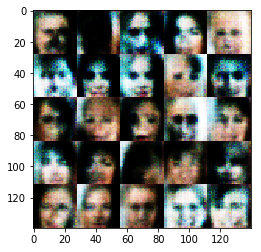

Epoch 1/1... D Loss: 0.7029... G Loss: 1.8623
Epoch 1/1... D Loss: 0.7011... G Loss: 1.8859
Epoch 1/1... D Loss: 0.7262... G Loss: 1.9713
Epoch 1/1... D Loss: 0.7537... G Loss: 1.5411
Epoch 1/1... D Loss: 0.7114... G Loss: 1.8097
Epoch 1/1... D Loss: 0.7381... G Loss: 1.4516
Epoch 1/1... D Loss: 0.8256... G Loss: 1.8259
Epoch 1/1... D Loss: 0.7323... G Loss: 1.5156


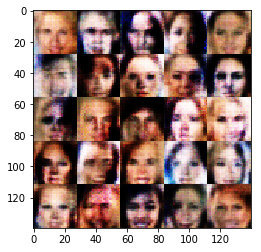

Epoch 1/1... D Loss: 0.7063... G Loss: 1.7417
Epoch 1/1... D Loss: 0.8188... G Loss: 1.2098
Epoch 1/1... D Loss: 0.6809... G Loss: 2.1064
Epoch 1/1... D Loss: 0.7423... G Loss: 1.5994
Epoch 1/1... D Loss: 0.7093... G Loss: 1.7585
Epoch 1/1... D Loss: 0.6960... G Loss: 1.8068
Epoch 1/1... D Loss: 0.6984... G Loss: 1.7529
Epoch 1/1... D Loss: 0.7335... G Loss: 1.5903


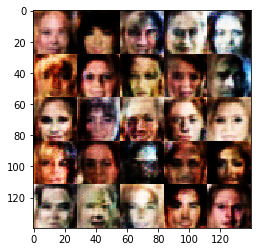

Epoch 1/1... D Loss: 0.9089... G Loss: 0.9841
Epoch 1/1... D Loss: 0.6926... G Loss: 2.2430
Epoch 1/1... D Loss: 0.6952... G Loss: 2.0646
Epoch 1/1... D Loss: 0.7362... G Loss: 1.5159
Epoch 1/1... D Loss: 0.6920... G Loss: 1.6873
Epoch 1/1... D Loss: 0.6843... G Loss: 2.0308
Epoch 1/1... D Loss: 0.6923... G Loss: 2.0253
Epoch 1/1... D Loss: 0.6878... G Loss: 1.8456


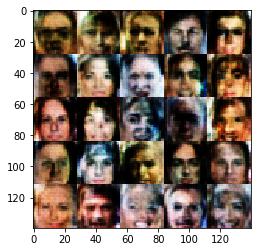

Epoch 1/1... D Loss: 0.8421... G Loss: 1.2550
Epoch 1/1... D Loss: 0.6854... G Loss: 2.2668
Epoch 1/1... D Loss: 0.6689... G Loss: 2.0318
Epoch 1/1... D Loss: 0.6819... G Loss: 1.8502
Epoch 1/1... D Loss: 0.6992... G Loss: 2.6063
Epoch 1/1... D Loss: 0.6835... G Loss: 1.9079
Epoch 1/1... D Loss: 0.6761... G Loss: 2.0949
Epoch 1/1... D Loss: 0.7100... G Loss: 1.7349


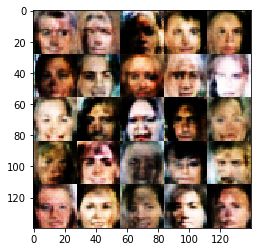

Epoch 1/1... D Loss: 0.6790... G Loss: 2.4572
Epoch 1/1... D Loss: 0.6649... G Loss: 2.1384
Epoch 1/1... D Loss: 0.7520... G Loss: 1.6837
Epoch 1/1... D Loss: 0.7288... G Loss: 1.5122
Epoch 1/1... D Loss: 0.7114... G Loss: 1.6201
Epoch 1/1... D Loss: 0.6937... G Loss: 2.4423
Epoch 1/1... D Loss: 0.7565... G Loss: 1.4071
Epoch 1/1... D Loss: 0.6793... G Loss: 2.3571


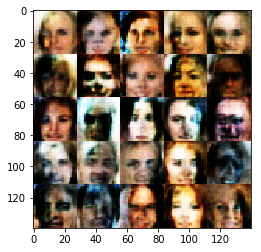

Epoch 1/1... D Loss: 0.6723... G Loss: 2.2300
Epoch 1/1... D Loss: 0.7766... G Loss: 1.3849
Epoch 1/1... D Loss: 0.6789... G Loss: 1.8209
Epoch 1/1... D Loss: 0.6650... G Loss: 2.0921
Epoch 1/1... D Loss: 0.6648... G Loss: 1.9472
Epoch 1/1... D Loss: 0.7003... G Loss: 2.8129
Epoch 1/1... D Loss: 0.6643... G Loss: 2.1057
Epoch 1/1... D Loss: 0.6915... G Loss: 2.6302


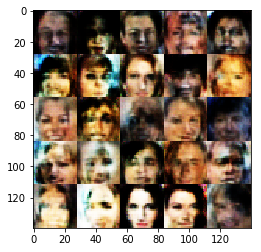

Epoch 1/1... D Loss: 0.6668... G Loss: 2.2612
Epoch 1/1... D Loss: 0.6714... G Loss: 2.3930
Epoch 1/1... D Loss: 0.6699... G Loss: 2.1107
Epoch 1/1... D Loss: 0.6654... G Loss: 2.1504
Epoch 1/1... D Loss: 0.6754... G Loss: 2.4576
Epoch 1/1... D Loss: 0.6770... G Loss: 2.0704
Epoch 1/1... D Loss: 0.6749... G Loss: 2.0288
Epoch 1/1... D Loss: 0.6663... G Loss: 1.9535


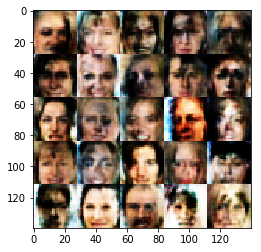

Epoch 1/1... D Loss: 0.6751... G Loss: 2.5306
Epoch 1/1... D Loss: 0.6981... G Loss: 2.0543
Epoch 1/1... D Loss: 0.6716... G Loss: 2.2631
Epoch 1/1... D Loss: 0.6613... G Loss: 2.0181
Epoch 1/1... D Loss: 0.6768... G Loss: 2.2512
Epoch 1/1... D Loss: 0.6672... G Loss: 2.0740
Epoch 1/1... D Loss: 0.6970... G Loss: 1.6902
Epoch 1/1... D Loss: 0.6679... G Loss: 2.1129


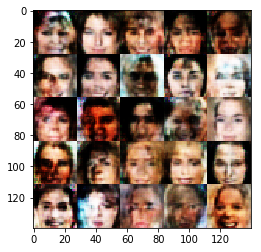

Epoch 1/1... D Loss: 0.6852... G Loss: 1.9931
Epoch 1/1... D Loss: 0.6707... G Loss: 2.2854
Epoch 1/1... D Loss: 0.6680... G Loss: 2.0485
Epoch 1/1... D Loss: 0.6678... G Loss: 2.0933
Epoch 1/1... D Loss: 0.6775... G Loss: 2.4292
Epoch 1/1... D Loss: 0.6644... G Loss: 2.1448
Epoch 1/1... D Loss: 0.6651... G Loss: 2.1449
Epoch 1/1... D Loss: 0.7827... G Loss: 1.2544


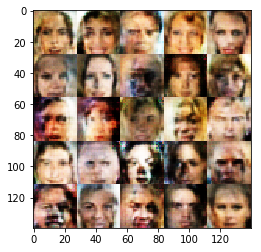

Epoch 1/1... D Loss: 0.6805... G Loss: 2.1889
Epoch 1/1... D Loss: 0.6877... G Loss: 2.1687
Epoch 1/1... D Loss: 0.8446... G Loss: 1.3882
Epoch 1/1... D Loss: 0.6690... G Loss: 2.1219
Epoch 1/1... D Loss: 0.6661... G Loss: 1.9404
Epoch 1/1... D Loss: 0.6745... G Loss: 2.2485
Epoch 1/1... D Loss: 0.7334... G Loss: 1.8750
Epoch 1/1... D Loss: 0.6677... G Loss: 2.1607


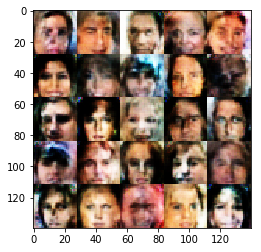

Epoch 1/1... D Loss: 0.6758... G Loss: 2.1579
Epoch 1/1... D Loss: 0.6740... G Loss: 1.9905
Epoch 1/1... D Loss: 0.6670... G Loss: 2.1471
Epoch 1/1... D Loss: 0.7119... G Loss: 3.0112
Epoch 1/1... D Loss: 0.6663... G Loss: 2.2208
Epoch 1/1... D Loss: 0.6725... G Loss: 2.2718
Epoch 1/1... D Loss: 1.0945... G Loss: 0.8939
Epoch 1/1... D Loss: 0.6693... G Loss: 1.9510


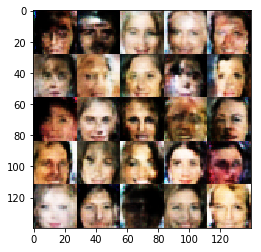

Epoch 1/1... D Loss: 0.6615... G Loss: 2.2096
Epoch 1/1... D Loss: 0.6920... G Loss: 2.0254
Epoch 1/1... D Loss: 0.6819... G Loss: 2.4378
Epoch 1/1... D Loss: 0.7222... G Loss: 1.5645
Epoch 1/1... D Loss: 0.6846... G Loss: 2.3752
Epoch 1/1... D Loss: 0.7741... G Loss: 1.7159
Epoch 1/1... D Loss: 0.6709... G Loss: 2.0202
Epoch 1/1... D Loss: 0.6696... G Loss: 2.1319


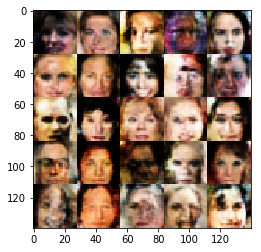

Epoch 1/1... D Loss: 0.6773... G Loss: 1.9753
Epoch 1/1... D Loss: 0.6632... G Loss: 2.0859
Epoch 1/1... D Loss: 0.6623... G Loss: 2.1725
Epoch 1/1... D Loss: 0.6659... G Loss: 2.1780
Epoch 1/1... D Loss: 0.7036... G Loss: 2.9849
Epoch 1/1... D Loss: 0.8488... G Loss: 1.1928
Epoch 1/1... D Loss: 0.6883... G Loss: 1.9107
Epoch 1/1... D Loss: 0.6676... G Loss: 2.1630


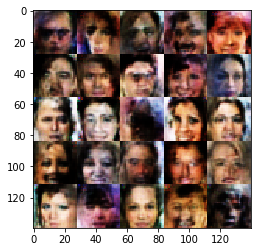

Epoch 1/1... D Loss: 0.6744... G Loss: 2.0106


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
alpha = 0.1
beta1 = 0.5
drop_rate = 0.
smoothing_rate = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha = alpha, drop_rate = drop_rate)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.